In [2]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import classical_mcmc
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)
from QuantumSamplingRoutines import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, transpiler
from qiskit.visualization import *

In [5]:
from qiskit_ibm_provider import IBMProvider
# # provider = IBMProvider(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628')
# # provider.save_account(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628', overwrite= True)
provider = IBMProvider()


#### **Testing Backend**

In [6]:
ibmq_guadalupe = provider.get_backend('ibmq_guadalupe'); ibmq_lima = provider.get_backend('ibmq_lima')

In [46]:
node_to_qubit_map = {0: 0, 1:1, 2:2, 3:3, 4:4, 5:6, 6:7, 7: 10}
qubit_to_node_map = dict([(item[1], item[0]) for item in node_to_qubit_map.items()])

map_node_to_qubit = lambda x: node_to_qubit_map[x]
map_qubit_to_node = lambda x: qubit_to_node_map[x]

In [45]:
node_to_qubit_map, qubit_to_node_map

({0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 6, 6: 7, 7: 10},
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6, 10: 7})

In [82]:
list(node_to_qubit_map.values())

[0, 1, 2, 3, 4, 6, 7, 10]

In [50]:
device_nodes = [0,1,2,3,4,6,7,10]
device_edges = [(0,1),(1,4),(4,7),(7,10),(7,6),(1,2),(2,3)]

graph_nodes = [0,1,2,3,4,5,6,7]

graph_edges = []
for edge in device_edges:
    i = map_qubit_to_node(edge[0])
    j = map_qubit_to_node(edge[1])
    new_edge = (i,j)
    graph_edges.append(new_edge)
    

In [52]:
graph_nodes, graph_edges

([0, 1, 2, 3, 4, 5, 6, 7],
 [(0, 1), (1, 4), (4, 6), (6, 7), (6, 5), (1, 2), (2, 3)])

In [53]:
trial_graph = nx.Graph(name= "ising_1")
trial_graph.add_nodes_from(graph_nodes)
trial_graph.add_edges_from(graph_edges)

h = [0.1, 0.3, 0.4, 0.21, 0.38, 0.15, 0.25, 0.10]
node_attr = {}
for index, node in enumerate(trial_graph.nodes) :

    node_attr[node] = {'h': np.round(h[index] * np.random.choice([1, -1]), 2)}

nx.set_node_attributes(trial_graph, node_attr)
edge_attr = {}
for edge in trial_graph.edges :
    edge_attr[edge] = {'J': np.round(np.random.uniform(-1,1),2)}

nx.set_edge_attributes(trial_graph, edge_attr)

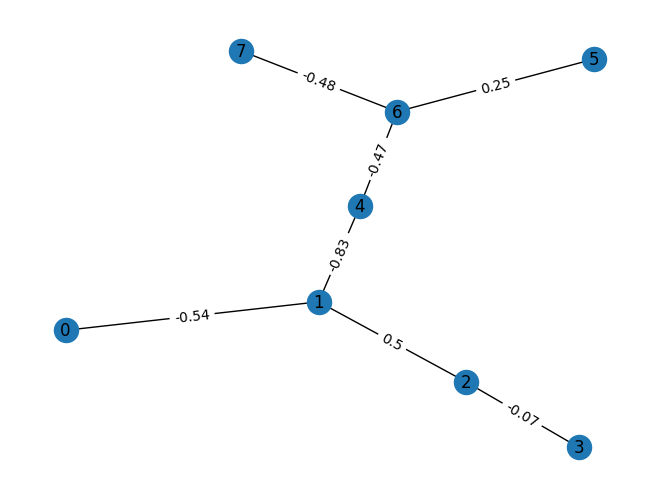

In [54]:
pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True,)
nx.draw_networkx_edge_labels(trial_graph, pos, edge_labels= nx.get_edge_attributes(trial_graph, 'J'));
# nx.draw_networkx_labels(trial_graph, pos, labels= nx.get_node_attributes(trial_graph, 'h'))


In [67]:
nx.get_edge_attributes(trial_graph, 'J')[(0,1)]

-0.54

In [71]:
list(nx.get_node_attributes(trial_graph, 'h').values())

[-0.1, -0.3, 0.4, -0.21, -0.38, -0.15, 0.25, -0.1]

In [76]:
def build_energy_function_from_graph(graph: nx.Graph, name:str = 's'):
    
    nspins = graph.number_of_nodes()
    j = nx.get_edge_attributes(graph, 'J')
    J = np.zeros((nspins, nspins))

    for edge in graph.edges():
        J[edge[0], edge[1]] = j[edge]
        J[edge[1], edge[0]] = j[edge]

    H = list(nx.get_node_attributes(graph, 'h').values())    

    return IsingEnergyFunction(J =J, h=H, name= 'sm1')

In [77]:
model = build_energy_function_from_graph(trial_graph)

            MODEL : sm1
Non-zero Interactions (J) : 7 / 28
Non-zero Bias (h) : 8 / 8
---------------------------------------------
Average Interaction Strength <|J|> :  0.09812499999999999
Average Bias Strength <|h|>:  0.23625000000000002
alpha :  1.867976369687995
---------------------------------------------


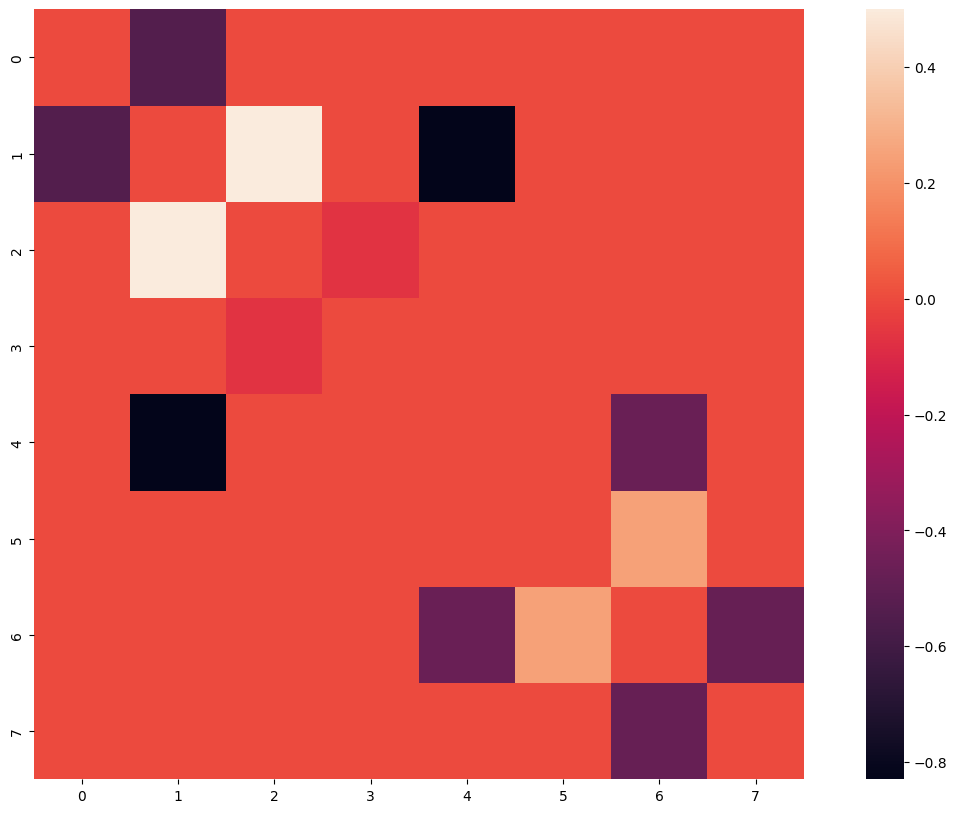

In [78]:
model.model_summary()

#### Final trial

In [79]:
sampling_job = QuantumSamplingJob(model, ibmq_guadalupe)

In [83]:
gamma= 0.4 ; time= 1.0 

qcs = sampling_job.run_quantum_circuit(gamma, time, return_quantum_circuit= True)
qcs = transpile(qcs, ibmq_guadalupe, optimization_level=3, initial_layout= list(node_to_qubit_map.values()) )

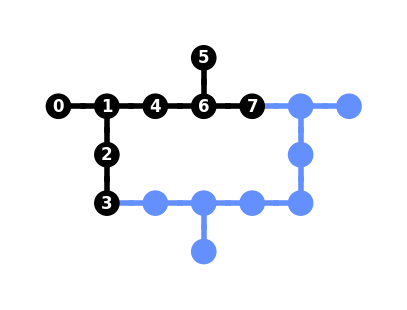

In [85]:
plot_circuit_layout(qcs, ibmq_guadalupe)

#### **Test Trial**

In [31]:
nspin = 2
seed = 10923; name = 'n'+str(nspin)+'sd'+str(seed)
model = random_ising_model(n_spins=nspin, seed= seed, print_model= False)
model.name = name

model.model_summary(plot = False)

            MODEL : n2sd10923
Non-zero Interactions (J) : 1 / 1
Non-zero Bias (h) : 2 / 2
---------------------------------------------
Average Interaction Strength <|J|> :  0.3425
Average Bias Strength <|h|>:  0.19
alpha :  1.909313313651758
---------------------------------------------


In [32]:
samplingjob = QuantumSamplingJob(model=model, backend= ibmq_guadalupe)

In [33]:
gamma= 0.4 ; time= 1.0 

qcs = samplingjob.run_quantum_circuit(gamma, time, return_quantum_circuit= True)

In [12]:
qcs.draw()

┌───┐┌─┐┌────────────────┐                   ░ ┌─┐   
q1_0: ┤ H ├┤M├┤ exp(-ia1X+b1Z) ├───────────────────░─┤M├───
      ├───┤└╥┘└──────┬─┬───────┘┌────────────────┐ ░ └╥┘┌─┐
q1_1: ┤ H ├─╫────────┤M├────────┤ exp(-ia0X+b0Z) ├─░──╫─┤M├
      └───┘ ║        └╥┘        └────────────────┘ ░  ║ └╥┘
c2: 2/══════╩═════════╩═══════════════════════════════╬══╬═
            0         1                               ║  ║ 
c3: 2/════════════════════════════════════════════════╩══╩═
                                                      0  1

In [34]:
qcs_tr = transpile(qcs, backend= ibmq_guadalupe, optimization_level= 3, initial_layout= [3,5])

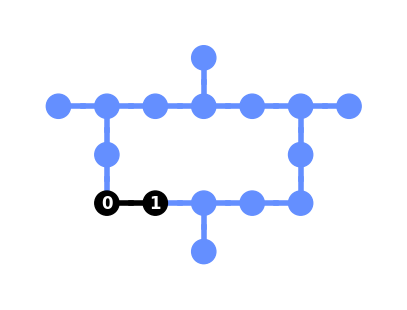

In [37]:
plot_circuit_layout(qcs_tr, ibmq_guadalupe)

In [35]:
qcs_tr.draw()

global phase: 3π/2
                                                                            »
  ancilla_0 -> 0 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_1 -> 1 ───────────────────────────────────────────────────────────»
                                                                            »
  ancilla_2 -> 2 ───────────────────────────────────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐┌─┐┌────────────┐    ┌────┐    »
       q7_0 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├┤M├┤ Rz(1.6942) ├────┤ √X ├────»
                 └─────────┘└────┘└─────────┘└╥┘└────────────┘    └────┘    »
  ancilla_3 -> 4 ─────────────────────────────╫─────────────────────────────»
                 ┌─────────┐┌────┐┌─────────┐ ║      ┌─┐      ┌────────────┐»
       q7_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─╫──────┤M├──────┤ Rz(1.3336) ├»
                 └─────────┘└────┘└─────────┘ ║      └╥┘      └────────────┘»
  ancilla_4 -> 6 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_5 -> 7 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_6 -> 8 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
  ancilla_7 -> 9 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_8 -> 10 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
 ancilla_9 -> 11 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_10 -> 12 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_11 -> 13 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_12 -> 14 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
ancilla_13 -> 15 ─────────────────────────────╫───────╫─────────────────────»
                                              ║       ║                     »
           c4: 2/═════════════════════════════╩═══════╩═════════════════════»
                                              0       1                     »
           c5: 2/═══════════════════════════════════════════════════════════»
                                                                            »
«                                                                              »
«  ancilla_0 -> 0 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_1 -> 1 ─────────────────────────────────────────────────────────────»
«                                                                              »
«  ancilla_2 -> 2 ─────────────────────────────────────────────────────────────»
«                 ┌─────────────┐     ┌────┐    ┌────────────┐               ░ »
«       q7_0 -> 3 ┤ Rz(-2.5032) ├─────┤ √X ├────┤ Rz(1.6942) ├───────────────░─»
«                 └─────────────┘     └────┘    └────────────┘               ░ »
«  ancilla_3 -> 4 ─────────────────────────────────────────────────────────────»
«                      ┌────┐    ┌─────────────┐    ┌────┐    ┌────────────┐ ░ »
«       q7_1 -> 5 ─────┤ √X ├────┤ Rz(-2.5074) ├────┤ √X ├────┤ Rz(1.3336) ├─░─»
«                      └────┘    └─────────────┘    └────┘    └────────────┘ ░ »
«  ancilla_4 -> 6 ────────────────────────

In [12]:
# with open('DATA/raw-circuit-outputs/mn2sd10923id1.pickle', 'rb') as hl:
#     qc = pickle.load(hl)